In [4]:
# 这个库在python中是用来进行画图
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import sklearn 

#  pandas是在python中进行处理数据的库
import pandas as pd
import os,sys,time

import tensorflow as tf
# keras有两类keras。我们可以自己进行选择，使用ts-keras还是keras。
# import keras
from tensorflow import keras

# 我们先进行打印一下我们所有的依赖库的版本号
print(tf.__version__)
print(sys.version_info)

for module in mpl,np,pd,sklearn,tf,keras:
    print(module.__name__,module.__version__)

2021-12-26 19:20:55.841127: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-26 19:20:55.841158: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.7.0
sys.version_info(major=3, minor=8, micro=12, releaselevel='final', serial=0)
matplotlib 3.5.1
numpy 1.21.4
pandas 1.3.5
sklearn 1.0.1
tensorflow 2.7.0
keras.api._v2.keras 2.7.0


In [5]:

# 我们使用keras来搭建一个分类模型.我们学习使用分类模型的，
# 我们可以kera内置的数据集。导入数据集fashion_mnist
fashion_mnist = keras.datasets.fashion_mnist
# 我们从这个kera内置的数据集fashion_mnist拆分出训练集和测试集
# python中通过变量
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
# 一般情况下，我们需要将训练集拆分成训练集和验证集
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

# 我们依次打印训练集、验证集、测试集的数据
print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [9]:
# 我们在所有的是训练集、验证集、测试集的数据，再增加一个归一化的数据

print("数据归一化之前:",np.max(x_train),np.min(x_train))

# x = (x - u) / std
# 均值：所有样本数据的平均值
# 方差：方差是在概率论和统计方差衡量随机变量或一组数据时离散程度的度量。
# 概率论中方差用来度量随机变量和其数学期望（即均值）之间的偏离程度。
# 统计中的方差（样本方差）是每个样本值与全体样本值的平均数之差的平方值的平均数。
# 上面是归一化的逻辑。上面 x 减去均值 除以方差。就得到了归一化的目的。

# 下面是实现方法：
# 我们从sklearn执行器里面导入StandardScaler
from sklearn.preprocessing import StandardScaler
# 进行StandardScaler(标准缩放器)的实例化
scaler = StandardScaler()
# x_train:[None,28,28] -> [None,784]

#  针对训练集进行归一化
# fit_transform将其转成归一化之后的矩阵。先转成二维的矩阵，然后再转成三维矩阵
x_train_scaled = scaler.fit_transform(x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
# 针对验证集进行归一化
x_valid_scaled = scaler.transform(x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
# 针对测试集进行归一化
x_test_scaled = scaler.transform(x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)

print("数据归一化之后:",np.max(x_train_scaled), np.min(x_train_scaled))

# TODO 为什么做数据归一化之后。模型的效果会好很多？？
# 稳定
# 波动变小


数据归一化之前: 255 0
数据归一化之后: 2.0231433 -0.8105136


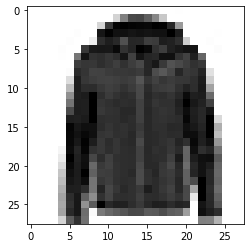

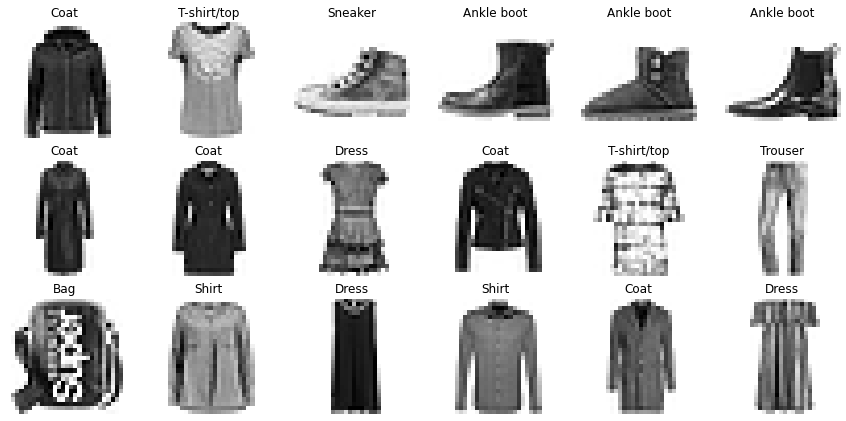

In [10]:
def show_single_image(img_array):
    plt.imshow(img_array,cmap="binary")
    plt.show()

    
show_single_image(x_train[0])

# 这个我们是从Tensorflow官网上面找到的。这个fashion_mnist数据集中各个图像对应的类别
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def show_all_images(n_rows,n_cols,x_data,y_data,class_names):
    assert len(x_data) == len(y_data)
    # 这里是需要断言，我们打印的数据数量不能大约原始数据集的数量
    assert n_rows * n_cols < len(x_data)
    # 配置我们需要显示的图片的size 我们是将
    plt.figure(figsize = (n_rows*5,n_cols *1.2))
    for row in range(n_rows):
        for col in range(n_cols):
            # 行列的数据转化为我们数据集中的index索引值
            index = n_cols * row + col
            plt.subplot(n_rows,n_cols,index+1)
            plt.imshow(x_data[index],cmap="binary",interpolation = 'nearest')
            plt.axis('off')
            # y_data数据集合中存储的是x_data里面图像的对应的名称
            plt.title(class_names[y_data[index]])
    plt.show()
# 我们按照三行五列的打印形式打印出这个数据集合    
show_all_images(3,6,x_train,y_train,class_names)            

In [12]:
# 下面，我们就可以进行构建我们的分类模型
# 我们使用tf.keras.models.Sequential(). 我们可以看到一下他的API

# https://tensorflow.google.cn/tutorials/keras/classification
# Sequential 将层的线性堆栈分组到 tf.keras.Model 中。继承自：模型、层、模块

"""
# 模型添加层的第一种方法
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))
"""

# 模型添加层的第二种方法
model = keras.models.Sequential([
    # 往模型对象里面添加层次。这一层是往模型里面添加输入28*28的图像  Flatten是展平为一维向量
    keras.layers.Flatten(input_shape=[28, 28]),
    # activation是激活函数
    # 全连接层就是神经网络中最普通的神经网络，下一层和上一层进行全连接
    keras.layers.Dense(300, activation='relu'),
    # 和上面一层进行全连接
    keras.layers.Dense(100, activation='relu'),
    # 这一层我们让他输出为长度为10的向量。因为我们的衣服种类就是十种
    # 将无限数值映射到
    keras.layers.Dense(10,activation='softmax')
])

# 激活函数：
#  relu: y=max(0,x) 输出x和0中最大的数字
# softmax 这个函数做的事情就是将向量编程概率分布。
#  具体的做法就是：x=[x1,x2,x3]
#  y=[e^x1/sum,e^x2/sum,e^x3/sum] sum = e^x1 + e^x2 + e^x3

#  loss 损失函数 sparse_categorical_crossentropy 就是交叉熵损失函数
# y是一个index的值  y->index y->one_hot ->
# optimizer="sgd" 模型的求解函数
# metrics = ["accuracy"] 把损失函数
model.compile(loss="sparse_categorical_crossentropy",
              optimizer ="sgd",
              metrics = ["accuracy"])


In [13]:
model.layers

In [14]:
model.summary()
# model.summary()是一个含很有用的函数。他可以打印出这个模型的概况。
# 他可以告诉我们模型中一共有多少个参数，有哪些参数是可以训练的。

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 300)               235500    
                                                                 
 dense_4 (Dense)             (None, 100)               30100     
                                                                 
 dense_5 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [15]:
# 我们可以开始进行训练模型了
# 下面的方法就是我们把训练集放到这个模型里面。并且epochs = 10我们进行训练10次
# 同时我们加入了验证数据集。validation_data=(x_valid,y_valid)这样每隔一段时间他就是进行验证。
# 这个训练方法是可以返回一个值的
history=model.fit(x_train_scaled,y_train,
                  epochs = 10,
                  validation_data=(x_valid_scaled,y_valid))

# TODO 模型训练并没有成功


Epoch 1/10
1719/1719 [==============================] - 2s 835us/step - loss: 0.5330 - accuracy: 0.8109 - val_loss: 0.4242 - val_accuracy: 0.8422
Epoch 2/10
1719/1719 [==============================] - 1s 794us/step - loss: 0.3928 - accuracy: 0.8596 - val_loss: 0.3735 - val_accuracy: 0.8644
Epoch 3/10
1719/1719 [==============================] - 1s 800us/step - loss: 0.3530 - accuracy: 0.8721 - val_loss: 0.3515 - val_accuracy: 0.8734
Epoch 4/10
1719/1719 [==============================] - 1s 863us/step - loss: 0.3272 - accuracy: 0.8808 - val_loss: 0.3369 - val_accuracy: 0.8756
Epoch 5/10
1719/1719 [==============================] - 1s 865us/step - loss: 0.3090 - accuracy: 0.8883 - val_loss: 0.3345 - val_accuracy: 0.8788
Epoch 6/10
1719/1719 [==============================] - 1s 859us/step - loss: 0.2915 - accuracy: 0.8927 - val_loss: 0.3347 - val_accuracy: 0.8746
Epoch 7/10
1719/1719 [==============================] - 1s 803us/step - loss: 0.2786 - accuracy: 0.8986 - val_loss: 0.3239 -

In [16]:
# History其实就是keras的一个callback的值
type(history)

keras.callbacks.History

In [17]:
history.history

{'loss': [0.5330478549003601,
  0.3928045332431793,
  0.35304343700408936,
  0.327243834733963,
  0.3090229034423828,
  0.29150763154029846,
  0.27857649326324463,
  0.26626405119895935,
  0.25472334027290344,
  0.24543069303035736],
 'accuracy': [0.8109272718429565,
  0.8595636487007141,
  0.8721091151237488,
  0.8808000087738037,
  0.8882545232772827,
  0.8927454352378845,
  0.8985999822616577,
  0.9017636179924011,
  0.9087454676628113,
  0.9100727438926697],
 'val_loss': [0.42418164014816284,
  0.3735010027885437,
  0.3515273332595825,
  0.3368760645389557,
  0.3344978392124176,
  0.33467552065849304,
  0.3239428997039795,
  0.3072017431259155,
  0.3280237913131714,
  0.3138332962989807],
 'val_accuracy': [0.842199981212616,
  0.8644000291824341,
  0.8733999729156494,
  0.8755999803543091,
  0.8787999749183655,
  0.8745999932289124,
  0.8823999762535095,
  0.8881999850273132,
  0.8769999742507935,
  0.8845999836921692]}

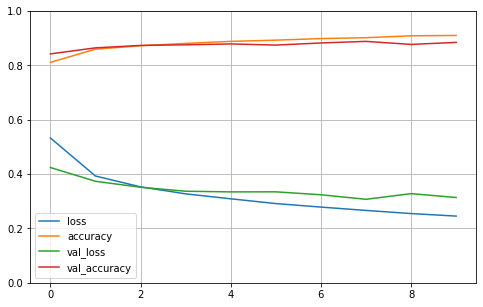

In [18]:
# 我们可以把上面的histoty按照图标的形式打印出来
def plot_learning_curves(history):
    # plot_learning_curves是pandas里面一个很重要的数据结构
    pd.DataFrame(history.history).plot(figsize=(8,5))
    # 显示成网格的形式
    plt.grid(True)
    # 我们设计数据的范围
    plt.gca().set_ylim(0,1)
    plt.show()

plot_learning_curves(history)    

In [19]:
# 我们在测试集合上来进行测试一下我们的模型。
model.evaluate(x_test_scaled,y_test)

313/313 [==============================] - 0s 481us/step - loss: 0.3439 - accuracy: 0.8793


[0.34389176964759827, 0.8792999982833862]